In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
data = pandas.read_csv('./integrals_with_metadata.txt',sep='\t')

In [2]:
data

,experiment_id,Harvest.Date,Run,Plate,Column,Row,species,normalized_OD,qpcr_4plex_Cy5.356.,qpcr_3plex_TR.360.,...,Hypoxanthine,unknown32,Adenine,unknown33,unknown34,unknown35,Formate,AMP,Nicotinate,Nicotinamide
0,164A,1/10/2017,1,6,4,A,"492,502",0.098167,NaN,NaN,...,0.014135,0.010405,0.064860,0.005110,0.006684,0.002684,0.013534,0.001123,0.007057,0.002967
1,224A,1/11/2017,2,2,4,A,"356,360",0.186158,3.624363,0.062894,...,0.033622,0.009804,0.031086,0.007056,0.017199,0.003422,0.019196,0.006320,0.009158,0.002559
2,273A,1/11/2017,2,7,3,A,"500,519",0.286358,0.000007,NaN,...,0.005929,0.011126,0.034464,0.007023,0.005531,0.003170,0.114830,0.001461,0.006193,0.005391
3,233A,1/11/2017,2,3,3,A,"356,500",0.183658,2.778331,NaN,...,0.034011,0.017737,0.011228,0.015492,0.009334,0.004416,0.021951,0.000931,0.008769,0.002198
4,144A,1/10/2017,1,4,4,A,"360,500",0.012067,NaN,1.163136,...,0.009275,0.009466,0.051925,0.006083,0.015608,0.002938,0.020428,0.008249,0.008088,0.002727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,381A,1/12/2017,3,8,1,A,0,0.005742,0.000018,NaN,...,0.007769,0.010287,0.012393,0.015175,0.010212,0.003860,0.024337,0.002428,0.003834,0.007004
280,111C,1/10/2017,1,1,1,C,356,0.186067,1.225792,NaN,...,0.034442,0.016565,0.011135,0.014990,0.009372,0.004724,0.019559,0.002801,0.008765,0.002081
281,131C,1/10/2017,1,3,1,C,"356,361",0.050467,0.272093,NaN,...,0.011056,0.010123,0.047652,0.014877,0.009637,0.004741,0.091361,0.003768,0.009443,0.001845
282,363C,1/12/2017,3,6,3,C,"492,500",0.018592,NaN,NaN,...,0.007864,0.012127,0.015643,0.013049,0.009235,0.003265,0.023208,0.000907,0.003771,0.005322


In [3]:
# dictionary of protons per compound in dissociated form;
# reference is TSP, which has 9 protons that generate the 
# peak at 0.0ppm (3 CH3 groups).

# Below are the peaks that were integrated in the original study:
# butyrate - triplet from CH3 at ~.99ppm
# acetate - singlet from CH3 at 1.9ppm
# propionate - triplet from CH3 at ~1.04ppm
# formate - singlet from 1 H at 8.44ppm
# isovalerate - doublet at ~0.91 from 6 hydrogens
# lactate - doublet from 3 hydrogens on CH3 at ~1.3ppm

protons = {'Acetate':3.0,
           'Formate':1.0,
           'Propionate':3.0,
           'Isovalerate':6.0,
           'Butyrate':3.0,
           'Lactate':3.0}

# M/S = IM/IS * NS/NM
# M = unknown concentration of the metabolite
# S = known concentration of the internal standard
# IM + IS = Integrals of the metabolite and standard, respectively
# NM + NS = Number of protons on the metabolite and standard, respectively
# M = S*(IM/IS * NS/NM)
ratios = {key:9.0/protons[key] for key,value in protons.items()}
#S, concentration of TSP
# concentration was 0.1% g/g, so 1g/L of TSP in the buffer
# 60uL of buffer was added to 540uL sample, so buffer was 10% of final solutions
tsp_na_salt_concentration = 0.1*1/172.27 # 10% * 1g/L / 172.27g/mol = mol/L
# All samples were standardized to an integral of 1 for the TSP peak

In [4]:
# load the raw spectra to get the area of TSP
tsp_na_salt_concentration

0.0005804841237592152

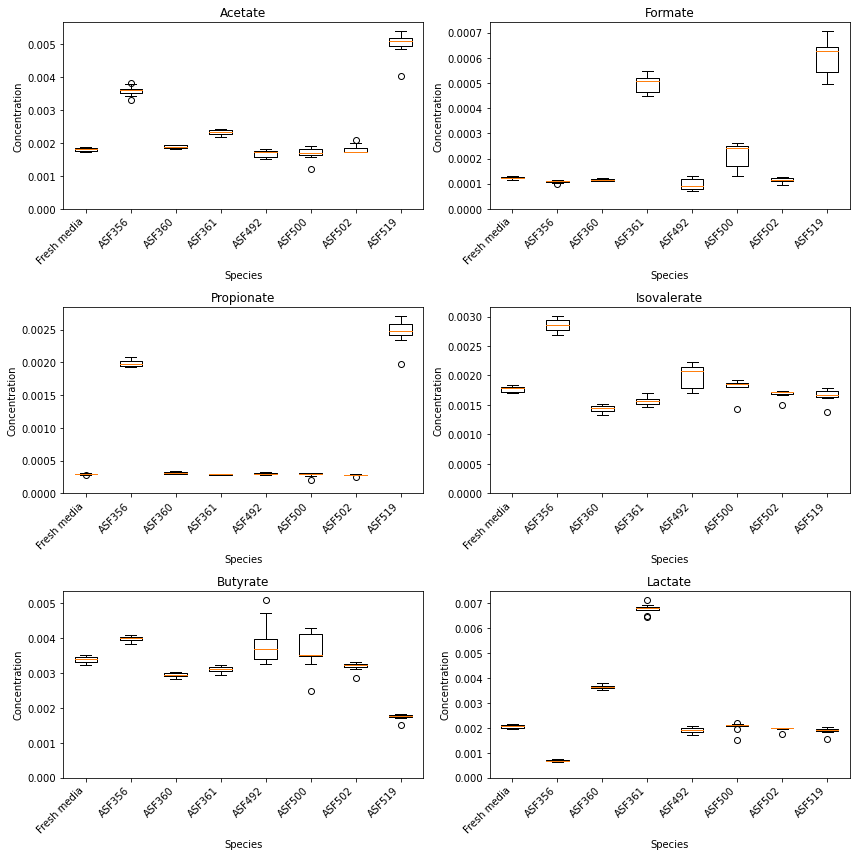

In [5]:
fig,axes = plt.subplots(3,2)
axes = np.ravel(axes)
species = ['0','356','360','361','492','500','502','519']
names = ["ASF"+x for x in species]
names[0] = "Fresh media"
# get only the monoculture samples, then sort by species for ordering in plots
monoculture_subset = data.loc[data['species'].isin(species)].sort_values('species')

metabolite_count = 0
for metabolite in protons.keys():
    concentration = tsp_na_salt_concentration*(monoculture_subset[metabolite] * ratios[metabolite])
    monoculture_subset[metabolite+'_abs_conc'] = concentration
    # generate a boxplot with whiskers at max/min, with a panel for each metabolite

    metabolite_df = pandas.pivot_table(monoculture_subset[['species',metabolite+'_abs_conc']],
               values=metabolite+'_abs_conc',
               index='species',
               aggfunc=list)
    metabolite_values = [np.asarray(x[0]) for x in metabolite_df.values]
    metabolite_labels = metabolite_df.index.tolist()
    axes[metabolite_count].boxplot(metabolite_values,labels=metabolite_labels)
    axes[metabolite_count].set_ylim(0,1.05*max([max(x) for x in metabolite_values]))
    axes[metabolite_count].set_ylabel("Concentration")
    axes[metabolite_count].set_xlabel("Species")
    axes[metabolite_count].set_xticklabels(labels=names,rotation=45,ha="right")
    axes[metabolite_count].set_title(metabolite)
    #plot horizontal line with mean value from fresh media
    #axes[metabolite_count].hlines(np.mean(metabolite_df.loc['0'].values[0]))
    metabolite_count+=1

fig.set_size_inches(12,12)
fig.tight_layout()
plt.savefig('./scfa_quantities.svg')
plt.show()